# 2.1 Keras 학습과정 확인
이번 실습에서는 모델이 학습하는 동안 변화하는 학습양상을 확인하는 방법을 알아본다  

In [ ]:
from keras.utils import np_utils
from keras import datasets
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
(X_train, Y_train),(X_test, Y_test) = datasets.mnist.load_data()
X_train_flat = X_train.reshape(60000, 28*28).astype('float32')/255.0
X_test_flat = X_test.reshape(10000, 28*28).astype('float32')/255.0
Y_train_onehot = np_utils.to_categorical(Y_train)
Y_test_onehot = np_utils.to_categorical(Y_test)

n_in = 28*28
n_out = np.shape(Y_test_onehot)[1]

In [ ]:
def DNN_seq(n_in, n_out):
    model = Sequential()
    model.add(Dense(units =128, input_shape=(n_in,), activation='relu'))
    model.add(Dense(units =32, activation='relu'))
    model.add(Dense(units =n_out, activation='softmax'))
    return model

In [ ]:
model = DNN_seq(n_in, n_out)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

## (1) Keras Callback
model의 fit() 함수로 학습을 진행하는 동안, 매 epoch마다 지정한 함수를 호출할 수 있음

ModelCheckpoint : 학습 중 모델 저장

EarlyStopping : 학습양상을 보고 학습을 조기에 종료

TensorBoard : tensorboard로 확인할 수 있도록 학습양상을 기록

외에 kereas.callbacks.Callback을 상속받아 원하는 callback 함수를 만들 수 있음
    
https://keras.io/callbacks/

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
import os
import datetime

학습과정을 저장할 directory 생성

In [ ]:
def make_dir(path):
    today = str(datetime.date.today())
    path_date = path+'/'+today
    
    if not os.path.exists(path_date):
        os.makedirs(path_date)
    return path_date

In [ ]:
model_path=make_dir('./model')
tensorboard_path=make_dir('./tensorboard')

modelconfig = str(n_in)+'_'+str(n_out)
model_name_path = model_path+'/'+modelconfig+"_{epoch:02d}-{loss:.4f}_{val_loss:.4f}_{val_accuracy:.4f}.h5"

print(model_name_path)
print(tensorboard_path)

필요한 callback 함수들을 정의하고 list로 fit() 함수에 전달

In [ ]:
checkpointer=ModelCheckpoint(filepath=model_name_path, monitor='val_accuracy', verbose=0, save_best_only=True)
tb_saver = TensorBoard(log_dir=tensorboard_path, write_graph=True)
earlystopper = EarlyStopping(monitor='val_accuracy', patience=40, verbose=0, mode='auto')

callback_list=[checkpointer, tb_saver, earlystopper]

In [ ]:
history = model.fit(X_train_flat, Y_train_onehot, batch_size=256, epochs=50, validation_split=0.3, verbose=2, callbacks = callback_list)

In [ ]:
os.listdir(model_path)

In [ ]:
os.listdir(tensorboard_path)

## (2) history 확인
fit() 함수는 history 객체를 반환함

history['loss']: epoch 마다 기록되는 train loss

history['accuracy'] : accuracy를 측정할 수 있는 문제이며 compile() 때 metric으로 accuracy를 지정하였다면 기록됨
    
history['val_loss'] : 검증 데이터가 있다면 기록되는 validation loss

history['val_accuracy'] : 검증 데이터가 있고 accuracy를 측정할 수 있다면 기록되는 validation accuracy 

In [ ]:
print(history.history['loss'])

matplotlib를 이용하여 history 객체 내부에 저장된 값들을 graph로 표현

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
fig_path=make_dir('./figure')
fig.savefig(fig_path+'/'+'final'+'.png')

## (3) 모델 저장하기, 불러오기
저장하기 : model 객체의 내부 함수인 save() .h5 형식으로 저장할 수 있음 [1.모델의 구조, 2.학습된 파라미터, 3.complie() 설정]

불러오기 : load_model 함수로 .h5 파일에서 모델을 불러올 수 있음

In [ ]:
from keras.models import load_model

In [ ]:
model = 1
model = load_model(model_path+'/'+'784_10_30-0.0002_0.1616_0.9753.h5')

In [ ]:
model.fit(X_train_flat, Y_train_onehot, batch_size=256, epochs=3, validation_split=0.3, verbose=2)

In [ ]:
model.save(model_path+'/'+'latest_model.h5')

## (4) tensorboard로 학습과정 확인하기
tensorflow의 가시화 툴인 tensorboard로 학습과정을 확인

[터미널] tensorboard --logdir=./tensorboard/날짜

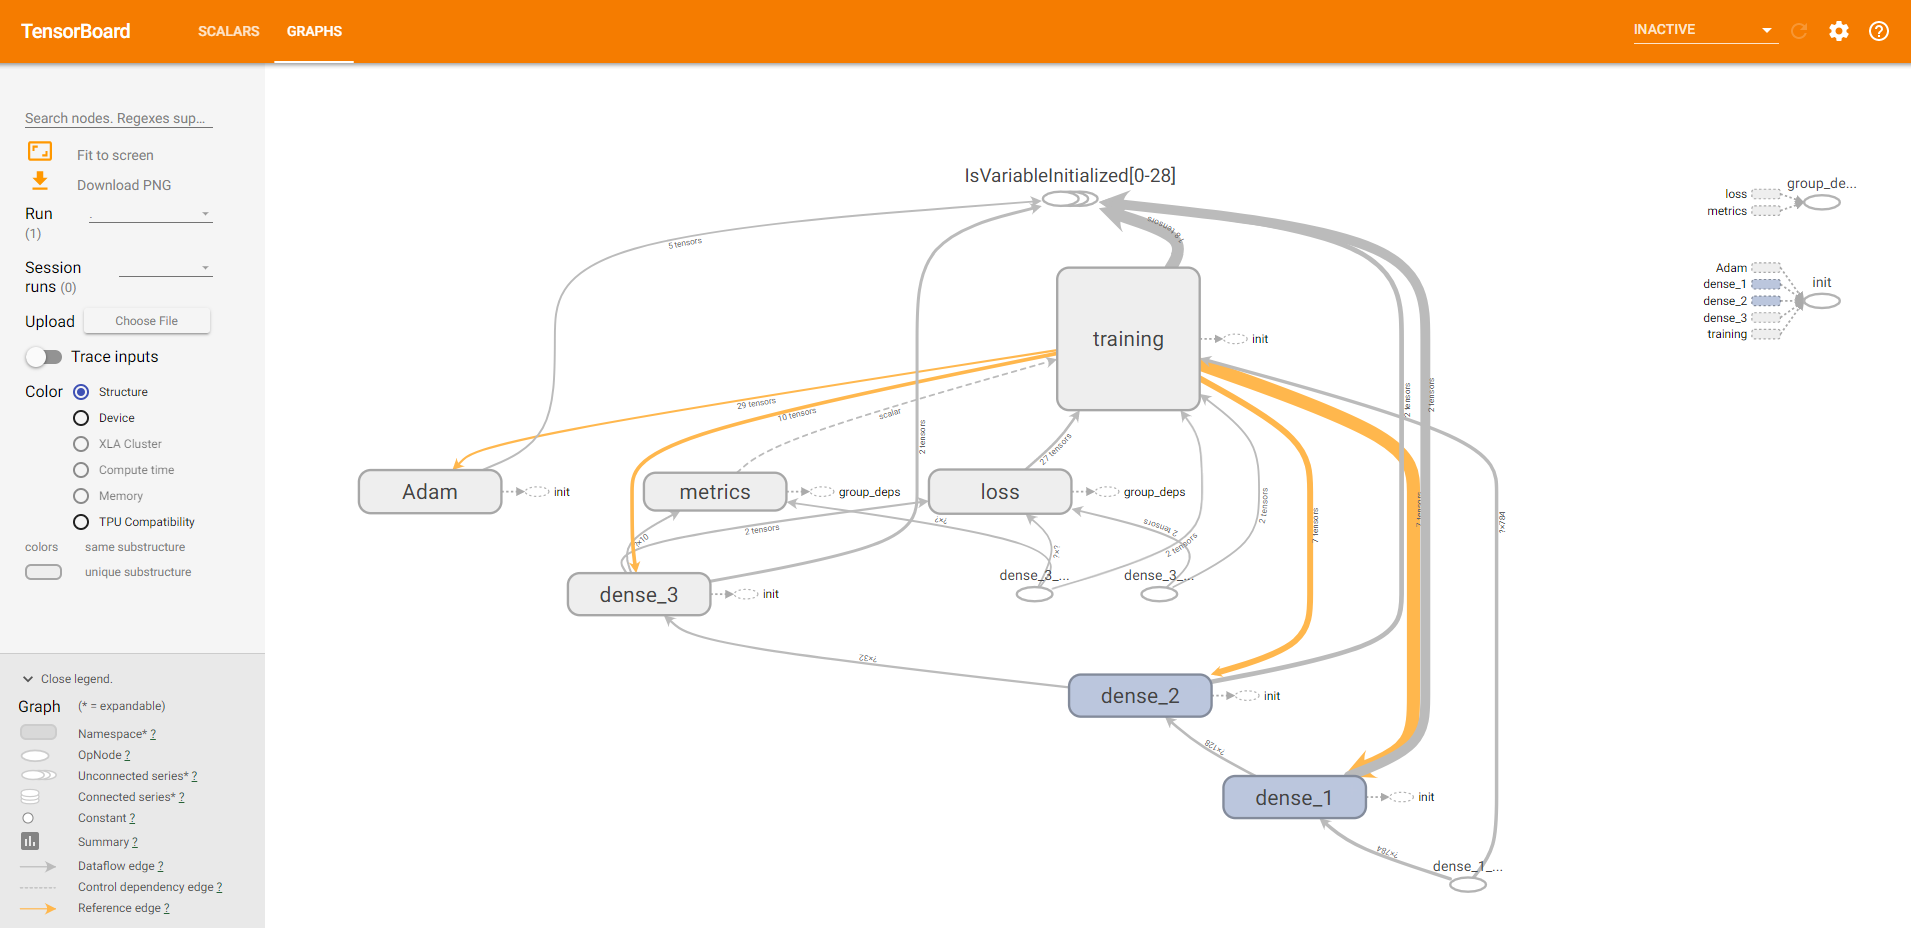

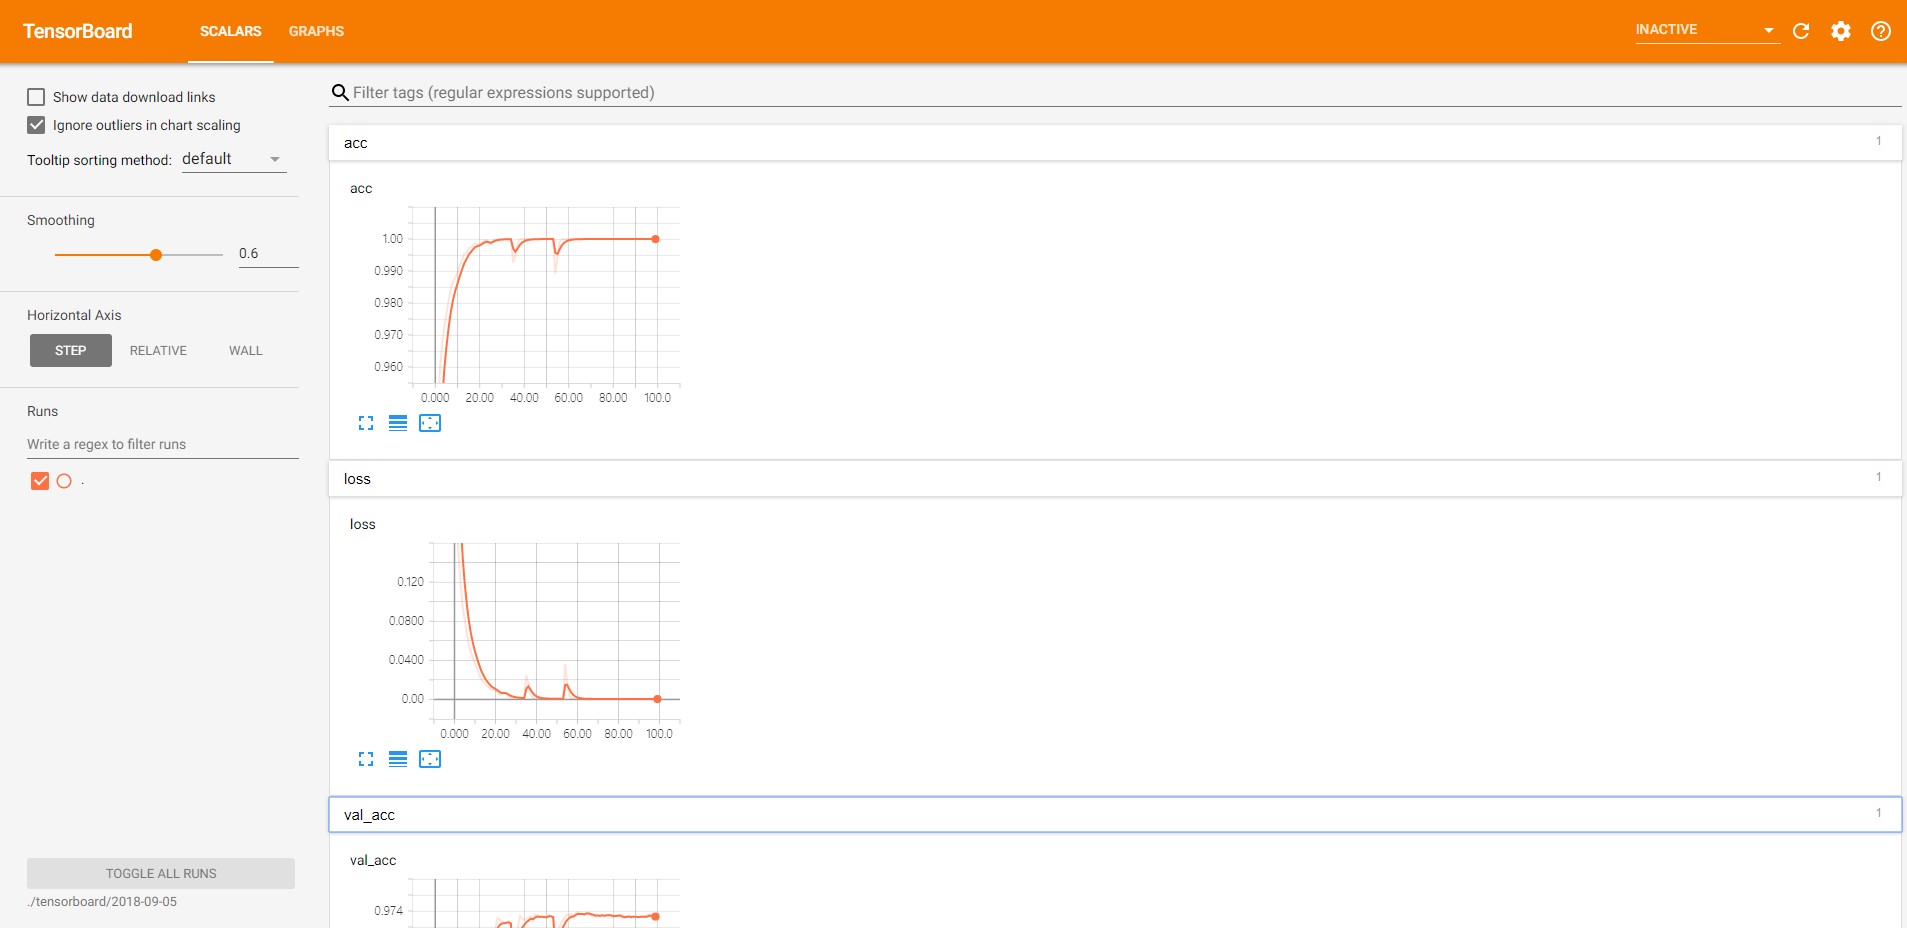